### prepare NBA players list and label 
### scrape NBA players' college data from basketball reference

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests

### Extract NBA player's list and VORP (label) data

In [93]:
player_info = defaultdict(list)
VORP = np.array([])
tables = []
for i in range(28):
    year = str(2017 - i)
    file = 'Dataset/NBA/' + year + '.csv'
    df = pd.read_csv(file)
    tables.append(df)
    for idx in range(len(df['Player'].values)):
        player_info[df['Player'].values[idx]].append((int(year), float(df.iloc[idx, -1])))
    VORP = np.append(VORP, df['VORP▼'].values)

In [94]:
## Merge the same player with two different names
player_info['Patty Mills\\millspa02'] += player_info['Patrick Mills\\millspa02']

In [95]:
del player_info['Patrick Mills\\millspa02']

In [96]:
player_VORP_max = defaultdict(float)
for player in player_info:
    info = player_info[player]
    m = -2.0
    for t in info:
        if t[1] > m:
            m = t[1]
    player_VORP_max[player] = m

In [24]:
player_list = list(player_info.keys())
player_list[0:6]

['Randell Jackson\\jacksra02',
 'Amir Johnson\\johnsam01',
 'Frankie King\\kingfr01',
 'Josh Richardson\\richajo01',
 'Cedric Hunter\\huntece01',
 'Elmore Spencer\\spencel01']

In [28]:
## There are 2291 NBA players from 1990 to 2017
len(player_list) 

2291

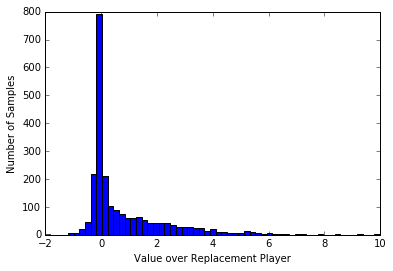

In [139]:
## Plot the distribution of VORP_max (label)
plt.hist(list(player_VORP_max.values()), np.linspace(-2, 10, 60))
plt.xlabel('Value over Replacement Player')
plt.ylabel('Number of Samples')

### Scrape the college statistics of all NBA players

In [25]:
player_id_list=[]
for i in player_list:
    name = i.split('\\')[1]
    init = name[0]
    ID = init + "/" + name 
    player_id_list.append(ID)

In [26]:
player_id_list[0:6]

['j/jacksra02',
 'j/johnsam01',
 'k/kingfr01',
 'r/richajo01',
 'h/huntece01',
 's/spencel01']

In [13]:
def college_data_scraper(url, name):
    ## scrape the college table
    req = requests.get(url)
    index = req.text.find('div_all_college_stats')
    text = req.text[index:]
    soup = BeautifulSoup(text, "html.parser")
    table = soup.find('table', id = 'all_college_stats')
    
    ## extract column headers
    column_headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    
    ## extract contents from the table
    data_rows = soup.findAll('tr')[2:]  # skip the first two columns
    player_data = [[td.getText() for td in data_rows[i].findAll('td')] 
               for i in range(len(data_rows))]
    
    ## extract the first column (season)
    season_data = [[th.getText() for th in data_rows[i].findAll('th')] 
               for i in range(len(data_rows))]
    season_data = np.reshape(season_data, -1)
    
    ## combine the columns and data as a data frame
    df = pd.DataFrame(player_data, columns=column_headers[1:])
    df["Season"] = season_data
    df["Name"] = name
    return(df)

In [14]:
base = 'http://www.basketball-reference.com/players/'
ext = '.html'
#player_list = ["b/bennean01","a/anderal01"]
college_df = pd.DataFrame()
for i in player_id_list:
    url = base + i + ext
    try:
        tmp = college_data_scraper(url, i)
        college_df = pd.concat([college_df, tmp])
        print(i)
    except:
        continue

In [23]:
## Initial data frame (college data for each player each year)
college_df.shape

(8636, 27)

In [19]:
## Among all 2291 players, we found 2001 players with college data
all_name =college_df.Name
len(all_name.unique())

2001

In [25]:
## write the table to csv
college_df.to_csv("college_raw_data.csv",index=False)

### Clean college raw data

1. Remove career rows
2. Delete row if column "G" < threshold (threshold = the max value of that person * 1/4)
3. Calculate FTA, FGA, 3PA, STL, BLK, TOV per game
4. Calcuate number of actual years played by length
5. Average all per game columns

http://www.basketball-reference.com/about/per.html

In [40]:
college_raw = pd.read_csv("Dataset/college_raw_data.csv")

In [41]:
college_raw.head(3)

,Age,College,G,MP,FG,FGA,3P,3PA,FT,FTA,...,PTS,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,Season,Name
0,19.0,TEXAS,34,1003.0,159.0,368.0,42.0,112.0,36.0,66.0,...,396,0.432,0.375,0.545,29.5,11.6,2.9,2.1,2009-10,b/bradlav01
1,NaN,NaN,34,1003.0,159.0,368.0,42.0,112.0,36.0,66.0,...,396,0.432,0.375,0.545,29.5,11.6,2.9,2.1,Career,b/bradlav01
2,19.0,MICHIGAN,31,403.0,34.0,56.0,0.0,1.0,16.0,35.0,...,84,0.607,0.000,0.457,13.0,2.7,3.3,0.5,1989-90,r/rileyer01


In [42]:
college_raw.columns

Index(['Age', 'College', 'G', 'MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
       'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%', '3P%',
       'FT%', 'MP.1', 'PTS.1', 'TRB.1', 'AST.1', 'Season', 'Name'],
      dtype='object')

#### 1. Remove career rows

In [43]:
college_clean = college_raw[college_raw.Season != "Career"]

In [44]:
## the final raw data has 6634 records
college_clean.shape

(6634, 27)

In [45]:
len(college_clean.Name.unique())

2001

#### 2. Delete row if column "G" < threshold

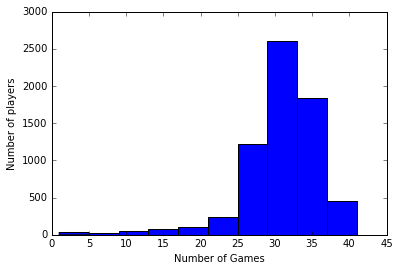

In [46]:
plt.hist(college_clean.G)
plt.xlabel('Number of Games')
plt.ylabel('Number of players')

In [47]:
temp2 = pd.DataFrame(college_clean.groupby(['Name'])['G'].max()*0.25)
temp2.reset_index(inplace=True)
temp2.columns = ['Name','Threshold']
college_clean = college_clean.merge(temp2, on="Name")
college_clean.head()

,Age,College,G,MP,FG,FGA,3P,3PA,FT,FTA,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,Season,Name,Threshold
0,19.0,TEXAS,34,1003.0,159.0,368.0,42.0,112.0,36.0,66.0,...,0.432,0.375,0.545,29.5,11.6,2.9,2.1,2009-10,b/bradlav01,8.50
1,19.0,MICHIGAN,31,403.0,34.0,56.0,0.0,1.0,16.0,35.0,...,0.607,0.000,0.457,13.0,2.7,3.3,0.5,1989-90,r/rileyer01,8.75
2,20.0,MICHIGAN,28,840.0,105.0,235.0,0.0,1.0,87.0,115.0,...,0.447,0.000,0.757,30.0,10.6,8.6,1.0,1990-91,r/rileyer01,8.75
3,21.0,MICHIGAN,32,480.0,82.0,139.0,NaN,NaN,37.0,64.0,...,0.590,NaN,0.578,15.0,6.3,4.3,0.7,1991-92,r/rileyer01,8.75
4,22.0,MICHIGAN,35,525.0,78.0,133.0,0.0,2.0,39.0,53.0,...,0.586,0.000,0.736,15.0,5.6,4.8,0.4,1992-93,r/rileyer01,8.75


In [48]:
college_clean = college_clean[college_clean.G >= college_clean.Threshold]
college_clean.head()

,Age,College,G,MP,FG,FGA,3P,3PA,FT,FTA,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,Season,Name,Threshold
0,19.0,TEXAS,34,1003.0,159.0,368.0,42.0,112.0,36.0,66.0,...,0.432,0.375,0.545,29.5,11.6,2.9,2.1,2009-10,b/bradlav01,8.50
1,19.0,MICHIGAN,31,403.0,34.0,56.0,0.0,1.0,16.0,35.0,...,0.607,0.000,0.457,13.0,2.7,3.3,0.5,1989-90,r/rileyer01,8.75
2,20.0,MICHIGAN,28,840.0,105.0,235.0,0.0,1.0,87.0,115.0,...,0.447,0.000,0.757,30.0,10.6,8.6,1.0,1990-91,r/rileyer01,8.75
3,21.0,MICHIGAN,32,480.0,82.0,139.0,NaN,NaN,37.0,64.0,...,0.590,NaN,0.578,15.0,6.3,4.3,0.7,1991-92,r/rileyer01,8.75
4,22.0,MICHIGAN,35,525.0,78.0,133.0,0.0,2.0,39.0,53.0,...,0.586,0.000,0.736,15.0,5.6,4.8,0.4,1992-93,r/rileyer01,8.75


In [49]:
sum(college_clean.G >= college_clean.Threshold) == college_clean.shape[0]

True

In [50]:
college_clean.shape

(6575, 28)

#### 3. Calculate FT, FTA, FGA, 3PA, STL, BLK, TOV per game

In [51]:
college_clean["FT"] = college_clean["FT"]/college_clean["G"]
college_clean["FTA"] = college_clean["FTA"]/college_clean["G"]
college_clean["FGA"] = college_clean["FGA"]/college_clean["G"]
college_clean["3PA"] = college_clean["3PA"]/college_clean["G"]
college_clean["STL"] = college_clean["STL"]/college_clean["G"]
college_clean["BLK"] = college_clean["BLK"]/college_clean["G"]
college_clean["TOV"] = college_clean["TOV"]/college_clean["G"]
college_clean["ORB"] = college_clean["ORB"]/college_clean["G"]
college_clean["PF"] = college_clean["PF"]/college_clean["G"]

#### 4. Add one feature: calcuate number of actual years played for each player

In [52]:
temp3 = pd.DataFrame(college_clean.groupby(['Name'])['G'].count())
temp3.reset_index(inplace=True)
temp3.columns = ['Name','Years']
college_clean = college_clean.merge(temp3, on="Name")
college_clean.head()

,Age,College,G,MP,FG,FGA,3P,3PA,FT,FTA,...,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,Season,Name,Threshold,Years
0,19.0,TEXAS,34,1003.0,159.0,10.823529,42.0,3.294118,1.058824,1.941176,...,0.375,0.545,29.5,11.6,2.9,2.1,2009-10,b/bradlav01,8.50,1
1,19.0,MICHIGAN,31,403.0,34.0,1.806452,0.0,0.032258,0.516129,1.129032,...,0.000,0.457,13.0,2.7,3.3,0.5,1989-90,r/rileyer01,8.75,4
2,20.0,MICHIGAN,28,840.0,105.0,8.392857,0.0,0.035714,3.107143,4.107143,...,0.000,0.757,30.0,10.6,8.6,1.0,1990-91,r/rileyer01,8.75,4
3,21.0,MICHIGAN,32,480.0,82.0,4.343750,NaN,NaN,1.156250,2.000000,...,NaN,0.578,15.0,6.3,4.3,0.7,1991-92,r/rileyer01,8.75,4
4,22.0,MICHIGAN,35,525.0,78.0,3.800000,0.0,0.057143,1.114286,1.514286,...,0.000,0.736,15.0,5.6,4.8,0.4,1992-93,r/rileyer01,8.75,4


In [54]:
college_clean.shape

(6575, 29)

### Scrape NCAA AP Poll

In [56]:
## Scrape college rating data
def AP_data_scraper(url):
    ## scrape the college table
    req = requests.get(url)
    text = req.text
    soup = BeautifulSoup(text, "html.parser")
    table = soup.find('table', id = 'ad')
    
    column_headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
    
    ## extract contents from the table
    data_rows = soup.findAll('tr')[2:27]  # skip the first two columns and til 25 rows
    cells = [[td.getText() for td in data_rows[i].findAll('td')] 
               for i in range(len(data_rows))]
    
    ## combine the columns and data as a data frame
    df = pd.DataFrame(cells, columns=column_headers[1:])
    return(df)

In [57]:
AP_poll_schools = defaultdict(list)

for i in range(2016, 1988, -1):
    url = "http://www.sports-reference.com/cbb/seasons/" + str(i) + "-polls.html"
    df = AP_data_scraper(url)
    
    names = np.array(df['School'].values.astype(str))
    for n in names:
        n = str.split(n, '\xa0*')[0]
        AP_poll_schools[i].append(n)

In [58]:
for colleges in AP_poll_schools.items():
    new = []
    for college in colleges[1]:
        new.append(college.upper())
    AP_poll_schools[colleges[0]] = new

In [59]:
AP = []
season = college_clean['Season'].values
school = college_clean['College'].values
for i in range(len(season)):
    year = int(season[i][:4]) + 1
    if school[i] in AP_poll_schools[year]:
        AP.append(1)
    else:
        AP.append(0)
college_clean['AP'] = AP

### Get Physcal Attributes Data

In [60]:
df = pd.read_csv('Dataset/Measurement.csv')

In [61]:
player_measurement_raw = {}
for name in df.PLAYER.astype(str):
    info = list(df[df['PLAYER'] == name].values[0,2:])
    for i in range(len(info)):
        if info[i] == '-':
            info[i] = np.nan
        else:
            info[i] = float(info[i])
    player_measurement_raw[name] = info

In [62]:
len(player_measurement_raw) ## only 1011 players have physical data

1011

In [64]:
player_measurement = {}
for name in player_info.keys():
    idx = name.find('\\')
    if name[:idx] in player_measurement_raw:
        player_measurement[name[idx+1:]] = player_measurement_raw[name[:idx]]

In [67]:
len(player_measurement) ## only 641 ppl of those 1011 players actually playing in NBA

641

In [68]:
tmp = college_clean['Name'].values
for i in range(len(tmp)):
    tmp[i] = tmp[i][2:]
college_clean['Name'] = tmp

In [69]:
college_clean['LAT'] = [np.nan] * len(college_clean)
college_clean['SR'] = [np.nan] * len(college_clean)
college_clean['TQS'] = [np.nan] * len(college_clean)
college_clean['SVL'] = [np.nan] * len(college_clean)
college_clean['MVL'] = [np.nan] * len(college_clean)
college_clean['MBP'] = [np.nan] * len(college_clean)

In [72]:
## add phycial attributes to the final dataset
count=0
for name in college_clean['Name'].unique():
    if name in player_measurement:
        count=count+1
        idx = college_clean[college_clean['Name'] == name].index.tolist()
        college_clean.loc[idx, ['LAT', 'SR', 'TQS', 'SVL', 'MVL', 'MBP']] = player_measurement[name]
print(count) # there are 591 players with physical data in the NCAA record

591


### Summarize each player data into one row using mean

In [73]:
college_average = pd.DataFrame(college_clean.groupby('Name').mean()).reset_index()
college_average.columns

Index(['Name', 'Age', 'G', 'MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%', '3P%', 'FT%',
       'MP.1', 'PTS.1', 'TRB.1', 'AST.1', 'Threshold', 'Years', 'AP', 'LAT',
       'SR', 'TQS', 'SVL', 'MVL', 'MBP'],
      dtype='object')

In [78]:
college_average[['Name','G', 'FGA', '3PA', 'FTA', 'ORB', 'TRB.1', 'AST.1', 'STL', 'BLK', 'TOV', 'PF', 'MP.1','PTS.1', 'FG%', '3P%', 'FT%', 'Years', 'AP', 'LAT',
       'SR', 'TQS', 'SVL', 'MVL', 'MBP']].head(6)

,Name,G,FGA,3PA,FTA,ORB,TRB.1,AST.1,STL,BLK,...,3P%,FT%,Years,AP,LAT,SR,TQS,SVL,MVL,MBP
0,abdelal01,33.500000,5.375016,NaN,2.340140,NaN,3.525,0.325,0.351910,0.484922,...,NaN,0.674000,4.0,0.500000,NaN,NaN,NaN,NaN,NaN,NaN
1,abdulma02,32.000000,21.890625,7.218750,6.406250,NaN,2.950,3.650,1.671875,0.109375,...,0.373500,0.862500,2.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,abdulta01,27.666667,11.285641,1.922756,4.859071,NaN,5.800,1.400,1.020833,0.599423,...,0.309667,0.678667,3.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
3,abdursh01,28.000000,14.214286,0.750000,8.892857,NaN,8.400,1.000,1.857143,1.250000,...,0.381000,0.683000,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,ackeral01,29.333333,11.107461,3.282642,3.524432,NaN,5.600,2.800,1.515493,0.430174,...,0.408333,0.822000,3.0,0.000000,11.67,NaN,3.35,28.0,32.0,11.0
5,acresma01,27.500000,12.562309,NaN,5.803502,NaN,9.475,NaN,1.376778,1.501394,...,NaN,0.697250,4.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
new_college=college_average[['Name','G', 'FGA', '3PA', 'FTA', 'ORB', 'TRB.1', 'AST.1', 'STL', 'BLK', 'TOV', 'PF', 'MP.1','PTS.1', 'FG%', '3P%', 'FT%', 'Years', 'AP', 'LAT',
       'SR', 'TQS', 'SVL', 'MVL', 'MBP']]

In [121]:
new_college.to_csv("Dataset/new_college.csv",index=False)

In [122]:
new_college=pd.read_csv("Dataset/new_college.csv")

### Merge college player's VORP to the final dataset

In [123]:
new_college.isnull().sum()

Name        0
G           0
FGA         2
3PA       320
FTA         2
ORB      1599
TRB.1       1
AST.1     141
STL       262
BLK       264
TOV       560
PF        666
MP.1      154
PTS.1       0
FG%         2
3P%       395
FT%         2
Years       0
AP          0
LAT      1482
SR       1887
TQS      1477
SVL      1472
MVL      1473
MBP      1529
dtype: int64

In [124]:
player_VORP_max_list = list(player_VORP_max.keys())
player_VORP_max_list[0:3] 

['Amir Johnson\\johnsam01',
 'Frankie King\\kingfr01',
 'Cedric Bozeman\\bozemce01']

In [125]:
player_VORP_max_name=[]
for i in player_VORP_max_list:
    name = i.split('\\')[1]
    player_VORP_max_name.append(name)

In [126]:
player_VORP_max_name[0:3]

['johnsam01', 'kingfr01', 'bozemce01']

In [127]:
player_VORP_max_value=list(player_VORP_max.values())

In [128]:
VORP_max_df = pd.DataFrame({'Name':player_VORP_max_name, 'VORP_Max':player_VORP_max_value})
VORP_max_df[0:6]

,Name,VORP_Max
0,johnsam01,3.2
1,kingfr01,0.0
2,bozemce01,-0.3
3,richajo01,0.7
4,huntece01,0.0
5,jonesch01,2.1


In [129]:
VORP_max_df[VORP_max_df['Name']=='millspa02'] # the duplicate name is successfully deleted

,Name,VORP_Max
1896,millspa02,2.0


In [130]:
new_college = new_college.merge(VORP_max_df, how='left',on="Name")

In [131]:
new_college.shape

(2001, 26)

In [132]:
new_college.head()

,Name,G,FGA,3PA,FTA,ORB,TRB.1,AST.1,STL,BLK,...,FT%,Years,AP,LAT,SR,TQS,SVL,MVL,MBP,VORP_Max
0,abdelal01,33.500000,5.375016,NaN,2.340140,NaN,3.525,0.325,0.351910,0.484922,...,0.674000,4.0,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,-0.2
1,abdulma02,32.000000,21.890625,7.218750,6.406250,NaN,2.950,3.650,1.671875,0.109375,...,0.862500,2.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.6
2,abdulta01,27.666667,11.285641,1.922756,4.859071,NaN,5.800,1.400,1.020833,0.599423,...,0.678667,3.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,0.2
3,abdursh01,28.000000,14.214286,0.750000,8.892857,NaN,8.400,1.000,1.857143,1.250000,...,0.683000,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.5
4,ackeral01,29.333333,11.107461,3.282642,3.524432,NaN,5.600,2.800,1.515493,0.430174,...,0.822000,3.0,0.000000,11.67,NaN,3.35,28.0,32.0,11.0,-0.1


In [133]:
new_college.to_csv("Dataset/new_college3.csv",index=False)